In [1]:
!pip install streamlit
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.7 MB/s eta 0:00:00


In [2]:
# Function to normalize values
def normalize(column):
    return (column - column.min()) / (column.max() - column.min())


# Function to calculate inverted normalization
def inverted_normalize(column):
    return 1 - normalize(column)


# Function to calculate Gaussian-like transformation for middle values
def middle_normalize(column):
    mean = column.mean()
    std = column.std()
    return np.exp(-((column - mean) ** 2) / (2 * std ** 2))

In [3]:
# Function to calculate overall grades
def calculate_overall_grade(df, year=2019):
    df_2019 = df[df['Year'] == year].copy()
    df_2019['Normalized Life Expectancy'] = normalize(df_2019['Life expectancy at birth, total (years)'])
    df_2019['Normalized Agricultural Land'] = inverted_normalize(df_2019['Agricultural land (% of land area)'])
    df_2019['Normalized Population Density'] = middle_normalize(
        df_2019['Population density (people per sq. km of land area)'])
    df_2019['Overall Grade'] = (
            df_2019['Normalized Life Expectancy'] +
            df_2019['Normalized Agricultural Land'] +
            df_2019['Normalized Population Density']
    ) / 3
    return df_2019[['Country Name', 'Overall Grade']].sort_values(by='Overall Grade', ascending=False)

In [4]:
# Prepare data for map
def prepare_map_data(df):
    df['Scaled Grade'] = normalize(df['Overall Grade'])
    df['Hover Info'] = df.apply(
        lambda row: f"{row['Country Name']}<br>Rating: {row['Scaled Grade']:.2f}"
        if not pd.isnull(row['Scaled Grade']) else f"{row['Country Name']}<br>Rating: Null",
        axis=1
    )
    return df


In [5]:
# Create interactive map with white background
def create_choropleth_map(df):
    colorscale = [
        [0, 'firebrick'], [0.1, 'crimson'], [0.2, 'tomato'], [0.3, 'orangered'],
        [0.4, 'orange'], [0.5, 'gold'], [0.6, 'limegreen'], [0.7, 'aquamarine'],
        [0.8, 'skyblue'], [0.9, 'royalblue'], [1, 'indigo']
    ]
    fig = go.Figure(data=go.Choropleth(
        locations=df['Country Name'],
        locationmode='country names',
        z=df['Scaled Grade'],
        text=df['Hover Info'],
        colorscale=colorscale,
        colorbar_title='Rating',
        marker_line_color='black',
        zmin=0,
        zmax=1,
        showscale=True
    ))
    fig.update_layout(
        title_text='Aggregated Country Ratings',
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type='equirectangular',
            bgcolor='white'  # Changed background to white
        )
    )
    return fig


In [6]:
# Function to plot indicators with bigger charts, titles, larger ticks, and ensure "No Data" visibility
def plot_indicators_for_country(df, country_name):
    country_data = df[df['Country Name'] == country_name]
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=False)  # Increased figsize

    def plot_indicator(ax, indicator, ylabel):
        combined_data = country_data[['Year', indicator]].copy()
        ax.plot(
            combined_data['Year'],
            combined_data[indicator],
            color='black', linestyle='-', marker='o', alpha=0.7
        )
        for i in range(1, len(combined_data)):
            year_prev = combined_data.iloc[i - 1]['Year']
            year_curr = combined_data.iloc[i]['Year']
            value_prev = combined_data.iloc[i - 1][indicator]
            value_curr = combined_data.iloc[i][indicator]
            if not (pd.isna(value_prev) or pd.isna(value_curr)):
                color = 'darkgreen' if year_curr <= 2019 else 'cornflowerblue'
                ax.plot([year_prev, year_curr], [value_prev, value_curr], color=color, linestyle='-', linewidth=2)

        # Highlight missing data
        missing_years = combined_data[combined_data[indicator].isna()]['Year']
        for year in missing_years:
            ax.axvspan(year - 0.5, year + 0.5, color='darksalmon', alpha=0.3)

        # Set labels, title, and grid
        ax.set_ylabel(ylabel, fontsize=24)  # Increased ylabel font size
        ax.set_xlabel('Year', fontsize=24)  # Increased xlabel font size
        ax.set_title(ylabel, fontsize=24)  # Increased title font size
        ax.grid(True)

        # Adjust tick label font size
        ax.tick_params(axis='both', which='major', labelsize=20)  # Increased tick label font size

    # Plot indicators on subplots
    plot_indicator(axs[0], 'Life expectancy at birth, total (years)', 'Life Expectancy (years)')
    plot_indicator(axs[1], 'Agricultural land (% of land area)', 'Agricultural Land (%)')
    plot_indicator(axs[2], 'Population density (people per sq. km of land area)', 'Population Density')

    # Customize legend and place it between title and plots
    handles = [
        plt.Line2D([0], [0], color='darkgreen', lw=2, label='Historical Data'),
        plt.Line2D([0], [0], color='cornflowerblue', lw=2, label='Predicted Data'),
        plt.Line2D([0], [0], color='darksalmon', lw=2, label='No Data')  # Explicitly include "No Data" in legend
    ]
    fig.legend(
        handles=handles,
        loc='upper center',
        ncol=3,
        frameon=False,
        fontsize=24,  # Increased font size to 24
        bbox_to_anchor=(0.5, 1.1)
    )

    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout to accommodate the legend
    return fig


In [7]:
# Streamlit App
st.title('Interactive Dashboard for Tracking and Forecasting UN SDG Progress')


2024-11-19 19:37:11.517 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 19:37:11.691 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-11-19 19:37:11.694 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [9]:
# Load data
df = pd.read_excel('Historical and Predicted Indicator Data.xlsx')
overall_grades = calculate_overall_grade(df)
map_data = prepare_map_data(overall_grades)

2024-11-19 19:37:38.493 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 19:37:38.494 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 19:37:38.497 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 19:37:38.499 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 19:37:38.502 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 19:37:38.503 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 19:37:38.505 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-19 19:37:38.506 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

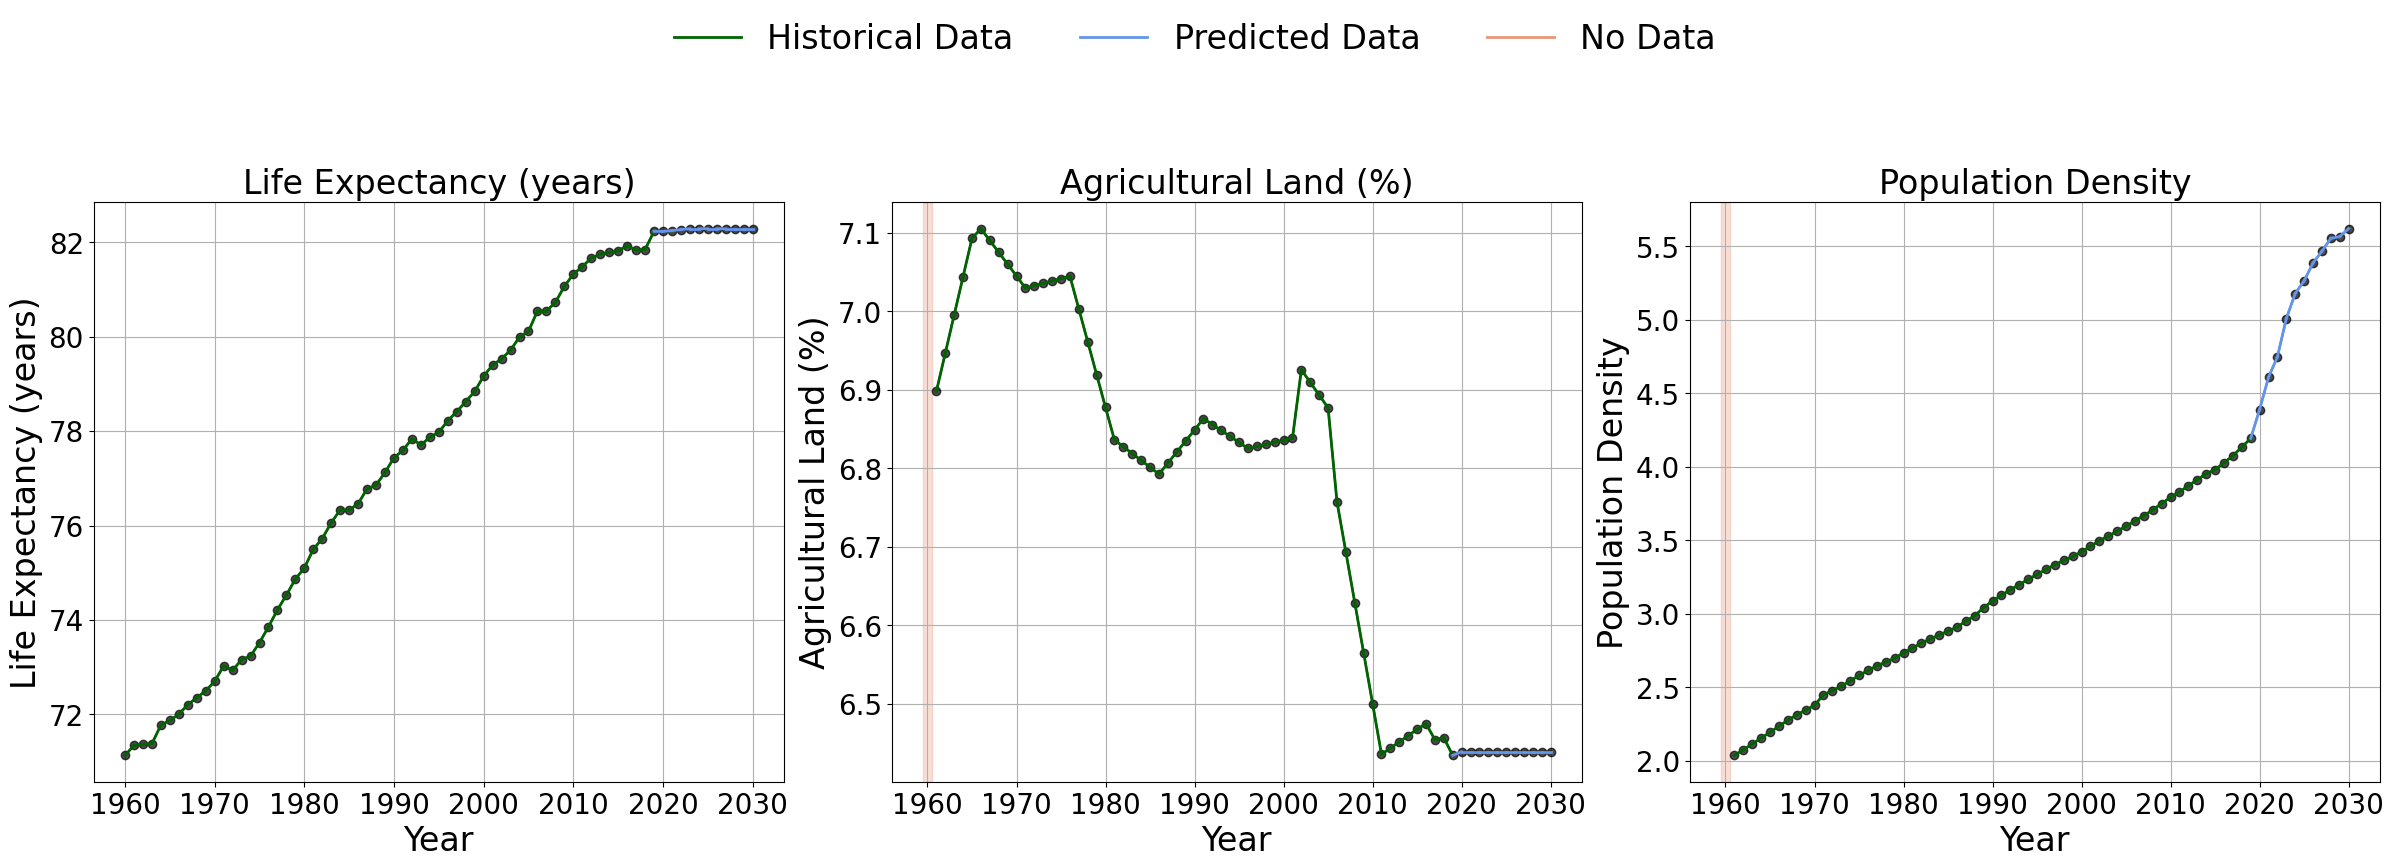

In [10]:
# Display interactive map
fig = create_choropleth_map(map_data)

st.plotly_chart(fig, use_container_width=True)

# Country-specific charts
st.subheader('Country Indicator Trends')

country_name = st.text_input('Enter a country name:', 'Canada')
if country_name:
    if country_name in df['Country Name'].unique():
        st.pyplot(plot_indicators_for_country(df, country_name))
    else:
        st.error(f"Country '{country_name}' not found in the dataset.")